###### Modules,Dependencies,Functions... Load data

In [1]:
from ROOT import TF2, TH1D, TF1, TFile, TCanvas
from root_numpy import random_sample
import root_numpy
from ROOT import gROOT 
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import scipy.fft
from scipy.optimize import curve_fit
#import mylib

def tfile_hist2array(tfile,hist_path):
    file=TFile( tfile, 'READ' )
    h=file.Get(hist_path)
    a=root_numpy.hist2array(h)
    return a

def tfile_vect2array(tfile,hist_path):
    file=TFile( tfile, 'READ' )
    item=file.Get(hist_path)
    Pitem=np.asarray(item)
    return Pitem

def myrfft(array, timebin):
    array_F = scipy.fft.rfft(array,len(array))
    xf_array = scipy.fft.rfftfreq(len(array), timebin)
    return array_F,xf_array

def expo_average(vector,alpha):
    v_averaged=np.zeros(len(vector))
    v_averaged[0]=vector[0]
    for i in range (len(vector)-1):
        v_averaged[i+1]=(1-alpha)*v_averaged[i]+alpha*vector[i+1]
    return v_averaged

def unweighted_average(vector):
    v_averaged=np.zeros(len(vector))
    v_averaged[0]=vector[0]
    v_averaged[-1]=vector[-1]

    for i in range (len(vector)-2):
        v_averaged[i+1]=(vector[i]+vector[i+1]+vector[i+2])/3
    return v_averaged

def plot_F(mps):
    for mp in mps:
        plt.plot(mp[1]/units[0],np.abs(mp[0]))  



Welcome to JupyROOT 6.22/08


Fourier transform

In [2]:
class my_wvf:
    smooth=False
    kernel_Done=False
    def __init__(self,f_type="",file_path="",item_path="",timebin=4e-9,normalize=False,item=np.zeros(1)):
        if f_type == "hist":
            self.wvf = tfile_hist2array(file_path,item_path)
        if f_type =="vector":
            self.wvf = tfile_vect2array(file_path,item_path)
        if f_type =="python":
            self.wvf = item
        if normalize:
            self.wvf=self.wvf/max(self.wvf)
        self.timebin=timebin
        N=len(self.wvf)
        self.wvf_x = x_time=np.linspace(0,N*timebin,N)
        self.doFFT()
        
    def apply_smooth(self,alfa):
        if self.smooth==False:
            self.wvf=expo_average(self.wvf,alfa)
            self.wvf=unweighted_average(self.wvf)
            self.smooth=True
            self.doFFT()
        else:
            print("Already smoothed")
    def doFFT(self):
        FFT=myrfft(self.wvf, self.timebin)
        self.wvf_F=FFT[0]
        self.wvf_F_x=FFT[1]
    def compute_kernel(self):
        if (not self.kernel_Done):
            print("code to compute the kernel here")
            
            self.kernel_Done=True
        else:
            print("Kernel already computed")
        
    def deconvolve_signal(self):
        #compute kernel in case is not done by this point.
        if not self.kernel_Done:
            self.compute_kernel()
        #deconvolve the signal (convolve with the kernel)
    def Resize(self,N):
        aux=self.wvf.copy()
        aux.resize(N)
        self.wvf=aux
        N=len(self.wvf)
        self.wvf_x = x_time=np.linspace(0,N*self.timebin,N)
        self.doFFT()
    def subs_baseline(self):
        self.wvf=self.wvf-1500 # Rodrigo tenía puesto 1500 y yo 375
        self.doFFT()
    def deconvolve(self,denominator):
        self.wvf_deco_F=self.wvf_F/denominator
        self.wvf_deco=scipy.fft.irfft(self.wvf_deco_F)
def func(x, a, c):
    return a*np.exp(-x/c)

Definimos una función que hace todo el proceso, bastante precaria pero me ahorra tonterías de cambios de nombres sin sentido.

In [3]:
def deconvolute(sipm_name, laser_name, deconv_time = 2400, day = "20 October"):
    base_dir = '/pc/choozdsk01/palomare/SiPM/SC_Fuente_Alpha_Jan/AnalysisROOT/'
#     Load SiPM name
    inSiPMName = base_dir+sipm_name
    inSiPM = ROOT.TFile.Open(inSiPMName ,"READ")
    listkeys_SiPM = inSiPM.GetListOfKeys()
#     Load laser name
    inLaserName = base_dir+laser_name
    inLaser = ROOT.TFile.Open(inLaserName ,"READ")
    listkeys_Laser = inLaser.GetListOfKeys()
    # Dump histograms
    sipm = my_wvf("vector",inSiPMName,listkeys_SiPM[0].GetName())
    laser = my_wvf("vector",inLaserName,listkeys_Laser[0].GetName())
    # Calculate deconvolved
    deconvolved = sipm.wvf_F/laser.wvf_F
    # Plot freqs
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(sipm.wvf_F_x,abs(deconvolved))
    plt.plot(sipm.wvf_F_x,abs(sipm.wvf_F))
    plt.plot(sipm.wvf_F_x,abs(laser.wvf_F))
    plt.grid(which="both"); plt.semilogy(); plt.semilogx();
    plt.legend(["Deconvolved", "SiPM", "Laser"])
    plt.xlabel("Freq (Hz)")
    plt.show()
    # Probably tail is problematic
    print("Check deconvolved time!!")
    deconvolved_short=deconvolved[:deconv_time]
    deconvolved_time=scipy.fft.irfft(deconvolved_short)
    fig=plt.figure(figsize=(6,4), dpi= 90, facecolor='w', edgecolor='k')
    plt.plot(abs(deconvolved))
    plt.plot(abs(deconvolved_short))
    plt.semilogy(); plt.show()
    
    deco1=my_wvf("python",item=deconvolved_time)
    deco1_maxindex = np.where(deco1.wvf==max(deco1.wvf))[0][0] # Bin where deconvolved signal reaches max
    deco1_13us = np.where(deco1.wvf_x>1.3e-6)[0][0] # Bin where 1.3 us
    index_diff = deco1_maxindex-deco1_13us # Bin difference in order to place max in 1.3us
    ls = [] # Empty list for tau values
    
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    fig=plt.figure(figsize=(6,4), dpi= 200, facecolor='w', edgecolor='k')
    plt.plot(deco1.wvf_x,deco1_mod)
    popt, pcov = curve_fit(func, deco1.wvf_x[450:1000],deco1_mod[450:1000], p0=(1, 1e-6)) # Fit between 1.8 and 4 us
    y_before = func(deco1.wvf_x[450:1000], *popt)
    print("T_slow (pre-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    deco1.apply_smooth(0.6)
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    popt, pcov = curve_fit(func, deco1.wvf_x[450:1000],deco1_mod[450:1000], p0=(1, 1e-6))
    y_after = func(deco1.wvf_x[450:1000], *popt)
    print("T_slow (post-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    plt.plot(deco1.wvf_x,deco1_mod)
    plt.plot(deco1.wvf_x[450:1000],y_before)
    plt.plot(deco1.wvf_x[450:1000],y_after)
    plt.xlim([0,5e-6])
    plt.xlabel("Time (s)"); 
    plt.title("Scintillation Profile "+"("+day+")")
    plt.legend(["Pre-Smooth", "Post-Smooth",r'$\tau_{slow} =$'+str(round(ls[0],2)), r'$\tau_{slow} = $'+str(round(ls[1],2))])
    plt.semilogy()
    plt.show()

In [6]:
def deconvolution_noise(sipm_name, laser_name, noise_name, deconv_time = 2400, initial_time = 450, end_time = 1000, ch_sipm = 0, day = ""):
    base_dir = '/pc/choozdsk01/palomare/SiPM/SC_Fuente_Alpha_Jan/AnalysisROOT/'
#     Load SiPM name
    inSiPMName = base_dir+sipm_name
    inSiPM = ROOT.TFile.Open(inSiPMName ,"READ")
    listkeys_SiPM = inSiPM.GetListOfKeys()
#     Load laser name
    inLaserName = base_dir+laser_name
    inLaser = ROOT.TFile.Open(inLaserName ,"READ")
    listkeys_Laser = inLaser.GetListOfKeys()
    # Load Noise name
    inNoiseName = base_dir+noise_name
    inNoise = ROOT.TFile.Open(inNoiseName ,"READ")
    listkeys_Noise = inNoise.GetListOfKeys()
    
    # Dump histograms
    if ch_sipm == 0:
        sipm = my_wvf("vector",inSiPMName,listkeys_SiPM[0].GetName())
        laser = my_wvf("vector",inLaserName,listkeys_Laser[0].GetName())
        noise = my_wvf("vector",inNoiseName,listkeys_Noise[0].GetName())
    else:
        sipm = my_wvf("vector",inSiPMName,listkeys_SiPM[1].GetName())
        laser = my_wvf("vector",inLaserName,listkeys_Laser[1].GetName())
        noise = my_wvf("vector",inNoiseName,listkeys_Noise[1].GetName())
    
    # Plot signals and apply smooth
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    smooth=0.6;
    plt.plot(laser.wvf/max(laser.wvf))
    laser.apply_smooth(smooth)
    plt.plot(laser.wvf/max(laser.wvf))
    plt.plot(sipm.wvf/max(sipm.wvf))
    sipm.apply_smooth(smooth)
    plt.plot(sipm.wvf/max(sipm.wvf))
    plt.semilogy()
    plt.legend(["Laser Raw","Laser Raw+Smooth", "SiPM Raw", "SiPM Raw+Smooth"]); plt.xlabel("Bin number (1bin = 4ns)")
    plt.show()
    
    # Calculate Wiener filter
    wiener = abs(sipm.wvf_F)**2/(abs(sipm.wvf_F)**2+abs(noise.wvf_F)**2)
    wiener_laser = abs(laser.wvf_F)**2/(abs(laser.wvf_F)**2+abs(noise.wvf_F)**2)
    # Calculate deconvolved
    deconvolved = sipm.wvf_F/laser.wvf_F*wiener
#     deconvolved = sipm.wvf_F/laser.wvf_F*wiener*wiener_laser
    
    # Plot freqs
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(sipm.wvf_F_x,abs(deconvolved))
    plt.plot(sipm.wvf_F_x,abs(sipm.wvf_F))
    plt.plot(sipm.wvf_F_x,abs(laser.wvf_F))
    plt.grid(which="both"); plt.semilogy(); plt.semilogx();
    plt.legend(["Deconvolved", "SiPM", "Laser"])
    plt.xlabel("Freq (Hz)")
    plt.show()
    
    # Probably tail is problematic
    print("Check deconvolved time!!")
    deconvolved_short=deconvolved[:deconv_time]
    deconvolved_time=scipy.fft.irfft(deconvolved_short)
    fig=plt.figure(figsize=(6,4), dpi= 90, facecolor='w', edgecolor='k')
    plt.plot(abs(deconvolved))
    plt.plot(abs(deconvolved_short))
    plt.semilogy(); plt.show()
    
    deco1=my_wvf("python",item=deconvolved_time)
    deco1_maxindex = np.where(deco1.wvf==max(deco1.wvf))[0][0] # Bin where deconvolved signal reaches max
    deco1_13us = np.where(deco1.wvf_x>1.3e-6)[0][0] # Bin where 1.3 us
    index_diff = deco1_maxindex-deco1_13us # Bin difference in order to place max in 1.3us
    ls = [] # Empty list for tau values
    
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(deco1.wvf_x,deco1_mod)
    popt, pcov = curve_fit(func, deco1.wvf_x[initial_time:end_time],deco1_mod[initial_time:end_time], p0=(1, 1e-6)) # Fit between 1.8 and 4 us
    y_before = func(deco1.wvf_x[initial_time:end_time], *popt)
    print("T_slow (pre-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    deco1.apply_smooth(0.6)
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    popt, pcov = curve_fit(func, deco1.wvf_x[initial_time:end_time],deco1_mod[initial_time:end_time], p0=(1, 1e-6))
    y_after = func(deco1.wvf_x[initial_time:end_time], *popt)
    print("T_slow (post-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    plt.plot(deco1.wvf_x,deco1_mod)
    plt.plot(deco1.wvf_x[initial_time:end_time],y_before)
    plt.plot(deco1.wvf_x[initial_time:end_time],y_after)
    plt.xlim([0,5e-6])
    plt.xlabel("Time (s)"); 
    plt.title("Scintillation Profile "+"("+day+")")
    plt.legend(["Pre-Smooth", "Post-Smooth",r'$\tau_{slow} =$'+str(round(ls[0],2)), r'$\tau_{slow} = $'+str(round(ls[1],2))])
    plt.semilogy()
    plt.show()

In [ ]:
def deconvolution_days(sipms_name, laser_name, noise_name, deconv_time = 2400, initial_time = 450, end_time = 1000, ch_sipm = 0, day = ""):
    base_dir = '/pc/choozdsk01/palomare/SiPM/SC_Fuente_Alpha_Jan/AnalysisROOT/'
    for i in sipms_name
#     Load SiPM name
    inSiPMName = base_dir+sipm_name
    inSiPM = ROOT.TFile.Open(inSiPMName ,"READ")
    listkeys_SiPM = inSiPM.GetListOfKeys()
#     Load laser name
    inLaserName = base_dir+laser_name
    inLaser = ROOT.TFile.Open(inLaserName ,"READ")
    listkeys_Laser = inLaser.GetListOfKeys()
    # Load Noise name
    inNoiseName = base_dir+noise_name
    inNoise = ROOT.TFile.Open(inNoiseName ,"READ")
    listkeys_Noise = inNoise.GetListOfKeys()
    
    # Dump histograms
    if ch_sipm == 0:
        sipm = my_wvf("vector",inSiPMName,listkeys_SiPM[0].GetName())
        laser = my_wvf("vector",inLaserName,listkeys_Laser[0].GetName())
        noise = my_wvf("vector",inNoiseName,listkeys_Noise[0].GetName())
    else:
        sipm = my_wvf("vector",inSiPMName,listkeys_SiPM[1].GetName())
        laser = my_wvf("vector",inLaserName,listkeys_Laser[1].GetName())
        noise = my_wvf("vector",inNoiseName,listkeys_Noise[1].GetName())
    
    # Plot signals and apply smooth
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    smooth=0.6;
    plt.plot(laser.wvf/max(laser.wvf))
    laser.apply_smooth(smooth)
    plt.plot(laser.wvf/max(laser.wvf))
    plt.plot(sipm.wvf/max(sipm.wvf))
    sipm.apply_smooth(smooth)
    plt.plot(sipm.wvf/max(sipm.wvf))
    plt.semilogy()
    plt.legend(["Laser Raw","Laser Raw+Smooth", "SiPM Raw", "SiPM Raw+Smooth"]); plt.xlabel("Bin number (1bin = 4ns)")
    plt.show()
    
    # Calculate Wiener filter
    wiener = abs(sipm.wvf_F)**2/(abs(sipm.wvf_F)**2+abs(noise.wvf_F)**2)
    wiener_laser = abs(laser.wvf_F)**2/(abs(laser.wvf_F)**2+abs(noise.wvf_F)**2)
    # Calculate deconvolved
    deconvolved = sipm.wvf_F/laser.wvf_F*wiener*wiener_laser
    
    # Plot freqs
    fig=plt.figure(figsize=(6,4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(sipm.wvf_F_x,abs(deconvolved))
    plt.plot(sipm.wvf_F_x,abs(sipm.wvf_F))
    plt.plot(sipm.wvf_F_x,abs(laser.wvf_F))
    plt.grid(which="both"); plt.semilogy(); plt.semilogx();
    plt.legend(["Deconvolved", "SiPM", "Laser"])
    plt.xlabel("Freq (Hz)")
    plt.show()
    
    # Probably tail is problematic
    print("Check deconvolved time!!")
    deconvolved_short=deconvolved[:deconv_time]
    deconvolved_time=scipy.fft.irfft(deconvolved_short)
    fig=plt.figure(figsize=(6,4), dpi= 90, facecolor='w', edgecolor='k')
    plt.plot(abs(deconvolved))
    plt.plot(abs(deconvolved_short))
    plt.semilogy(); plt.show()
    
    deco1=my_wvf("python",item=deconvolved_time)
    deco1_maxindex = np.where(deco1.wvf==max(deco1.wvf))[0][0] # Bin where deconvolved signal reaches max
    deco1_13us = np.where(deco1.wvf_x>1.3e-6)[0][0] # Bin where 1.3 us
    index_diff = deco1_maxindex-deco1_13us # Bin difference in order to place max in 1.3us
    ls = [] # Empty list for tau values
    
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    fig=plt.figure(figsize=(6,4), dpi= 200, facecolor='w', edgecolor='k')
    plt.plot(deco1.wvf_x,deco1_mod)
    popt, pcov = curve_fit(func, deco1.wvf_x[initial_time:end_time],deco1_mod[initial_time:end_time], p0=(1, 1e-6)) # Fit between 1.8 and 4 us
    y_before = func(deco1.wvf_x[initial_time:end_time], *popt)
    print("T_slow (pre-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    deco1.apply_smooth(0.6)
    deco1_mod = np.concatenate((deco1.wvf[index_diff:],deco1.wvf[:index_diff]), axis = None)
    popt, pcov = curve_fit(func, deco1.wvf_x[initial_time:end_time],deco1_mod[initial_time:end_time], p0=(1, 1e-6))
    y_after = func(deco1.wvf_x[initial_time:end_time], *popt)
    print("T_slow (post-smooth) =",popt[1])
    ls.append(popt[1]*1e6)
    
    plt.plot(deco1.wvf_x,deco1_mod)
    plt.plot(deco1.wvf_x[initial_time:end_time],y_before)
    plt.plot(deco1.wvf_x[initial_time:end_time],y_after)
    plt.xlim([0,5e-6])
    plt.xlabel("Time (s)"); 
    plt.title("Scintillation Profile "+"("+day+")")
    plt.legend(["Pre-Smooth", "Post-Smooth",r'$\tau_{slow} =$'+str(round(ls[0],2)), r'$\tau_{slow} = $'+str(round(ls[1],2))])
    plt.semilogy()
    plt.show()

## Día 24 Enero

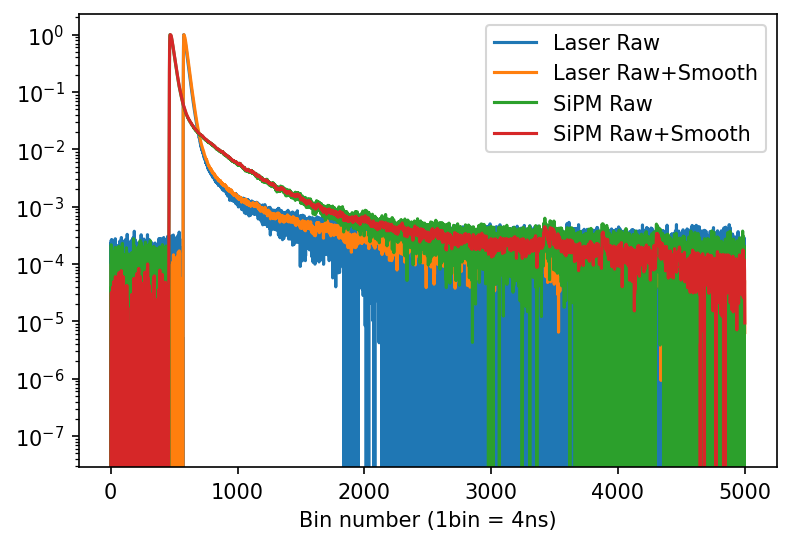

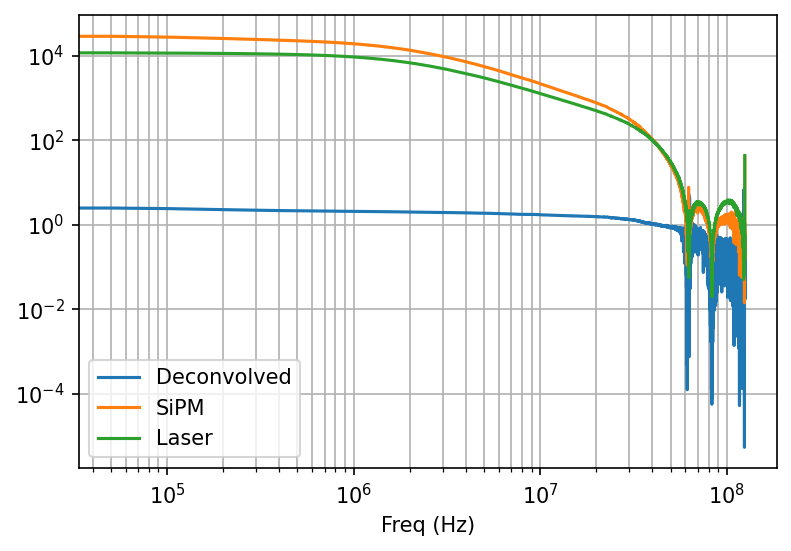

Check deconvolved time!!


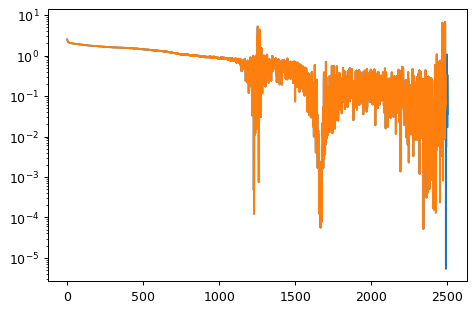

T_slow (pre-smooth) = 1.0142921006353686e-06
T_slow (post-smooth) = 9.56767263630268e-07


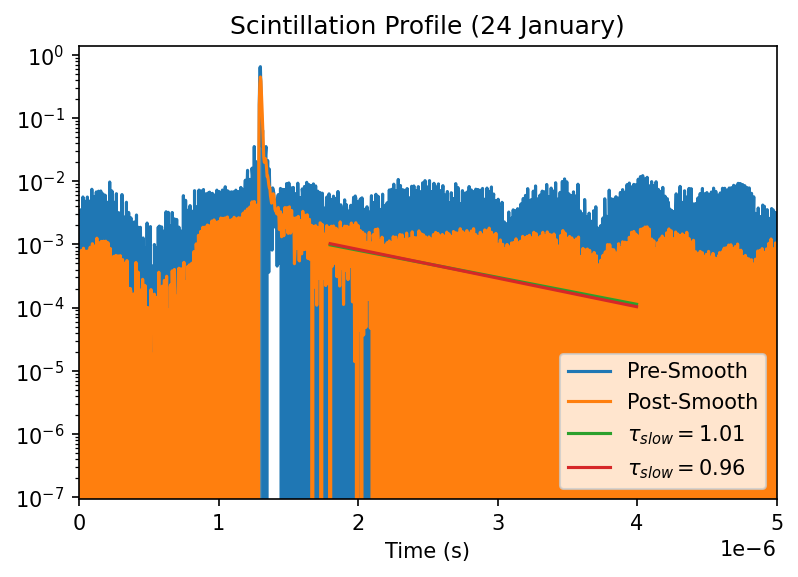

In [7]:
deconvolution_noise('run14_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run19_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 0, "24 January")

In [ ]:
deconvolution_noise('run13_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run19_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 1, "24 January")

## Día 25 Enero

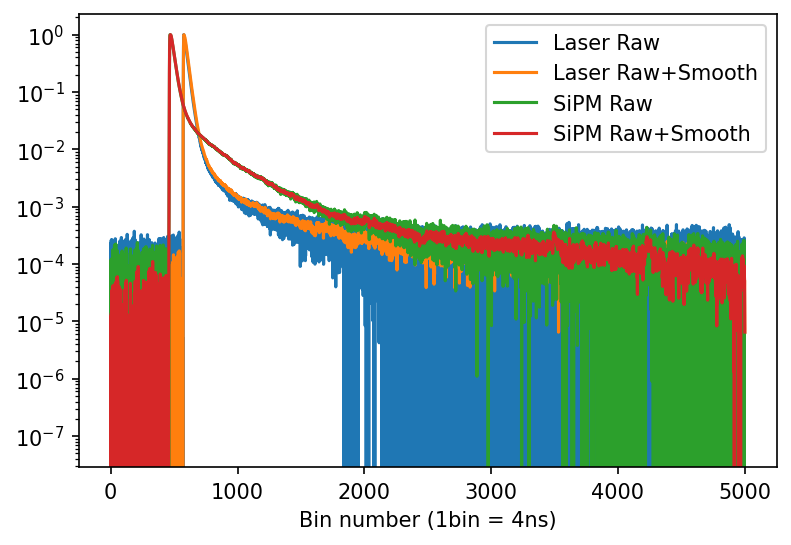

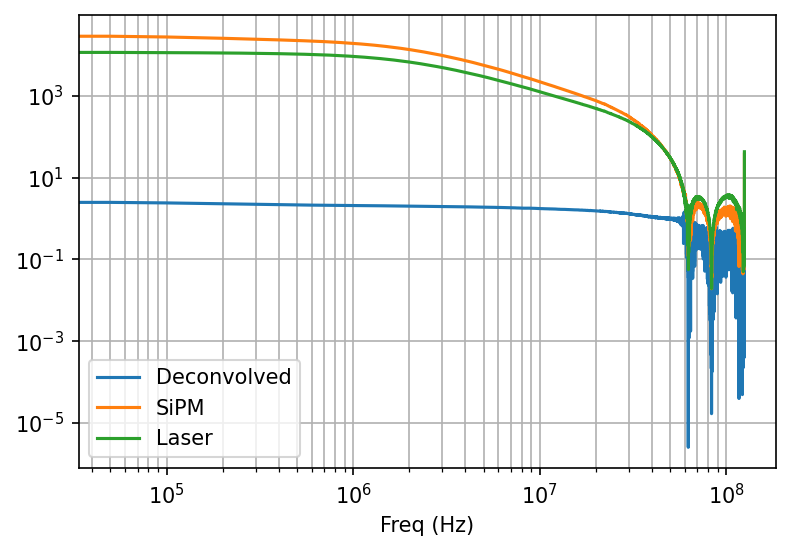

Check deconvolved time!!


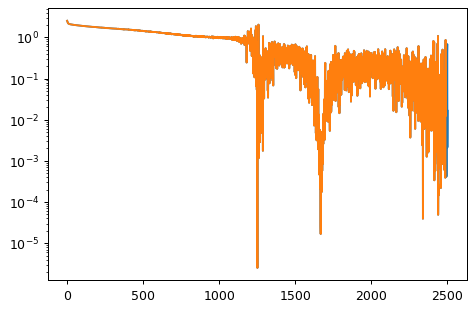

T_slow (pre-smooth) = 9.091214412094292e-07
T_slow (post-smooth) = 9.207605958651431e-07


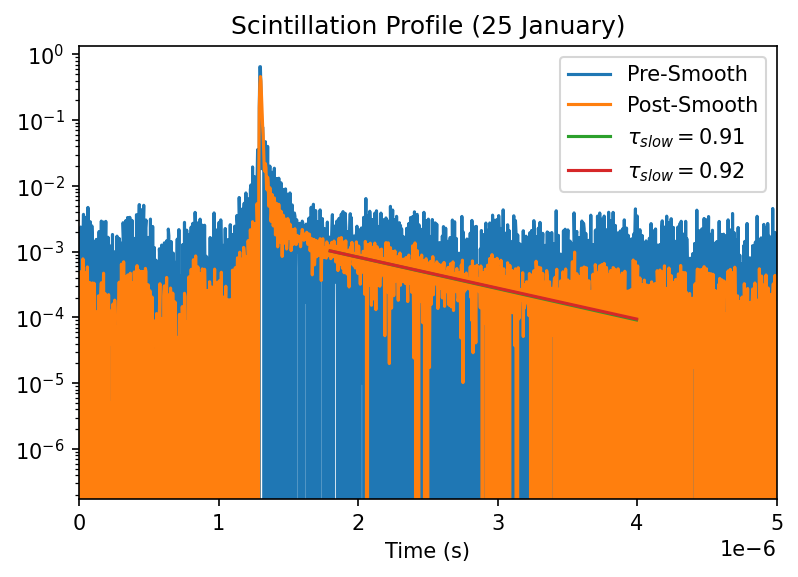

In [8]:
deconvolution_noise('run36_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run42_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 0, "25 January")

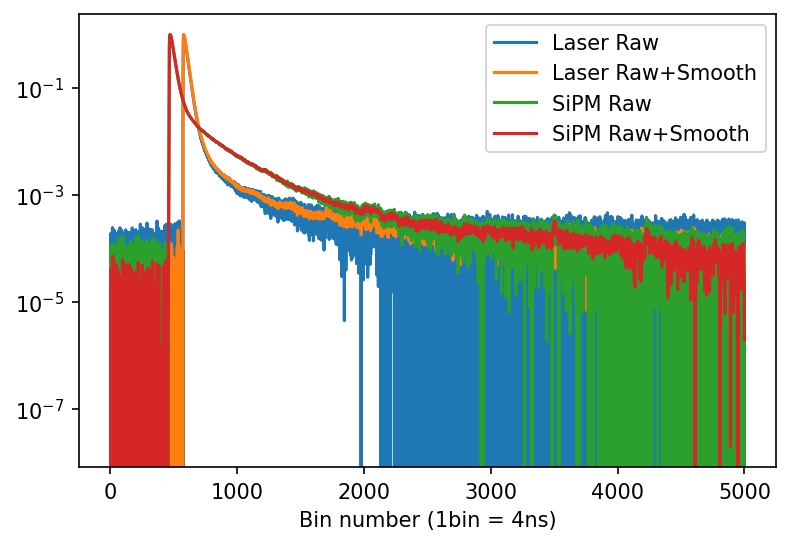

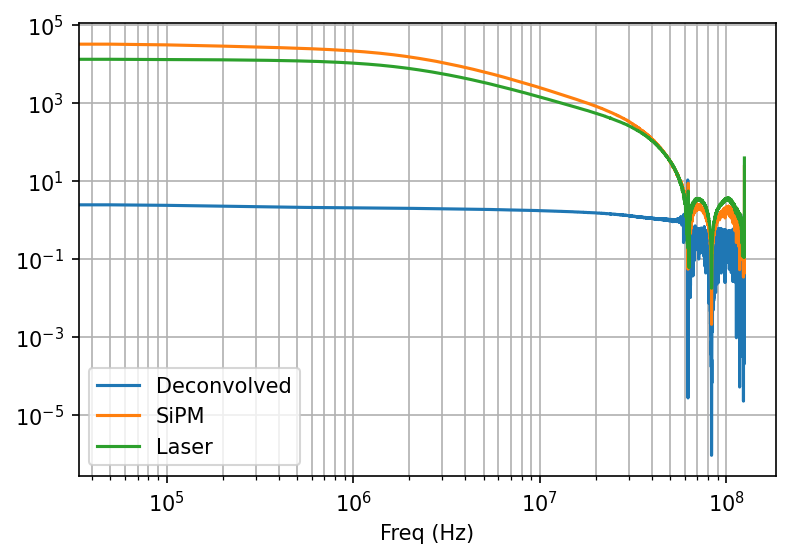

Check deconvolved time!!


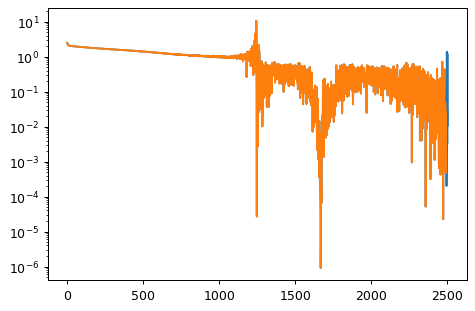

T_slow (pre-smooth) = 8.787312349557684e-07
T_slow (post-smooth) = 8.999489150726146e-07


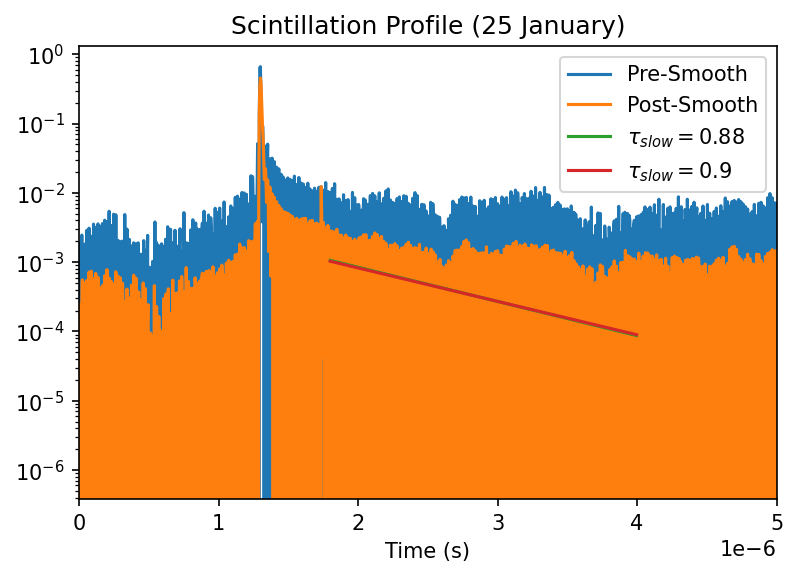

In [9]:
deconvolution_noise('run36_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run42_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 1, "25 January")

## Día 26 December

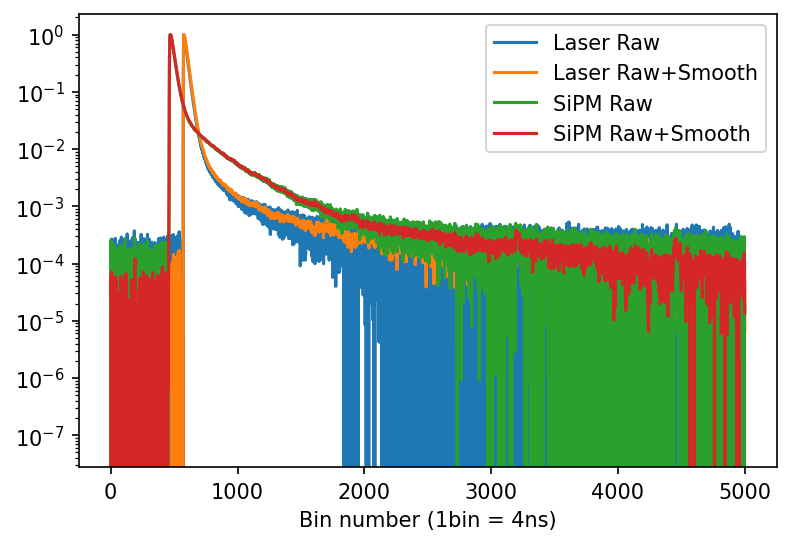

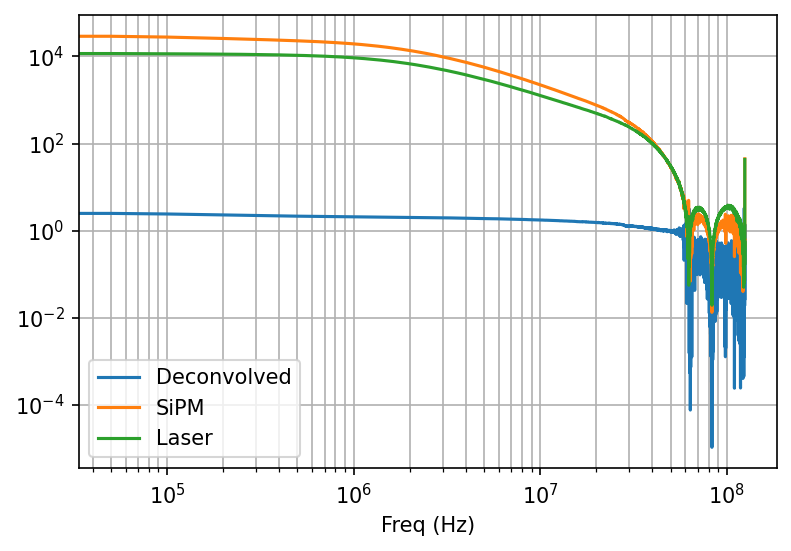

Check deconvolved time!!


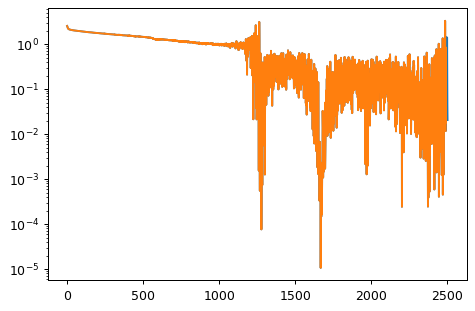

T_slow (pre-smooth) = 8.946933634477388e-07
T_slow (post-smooth) = 9.395970322166483e-07


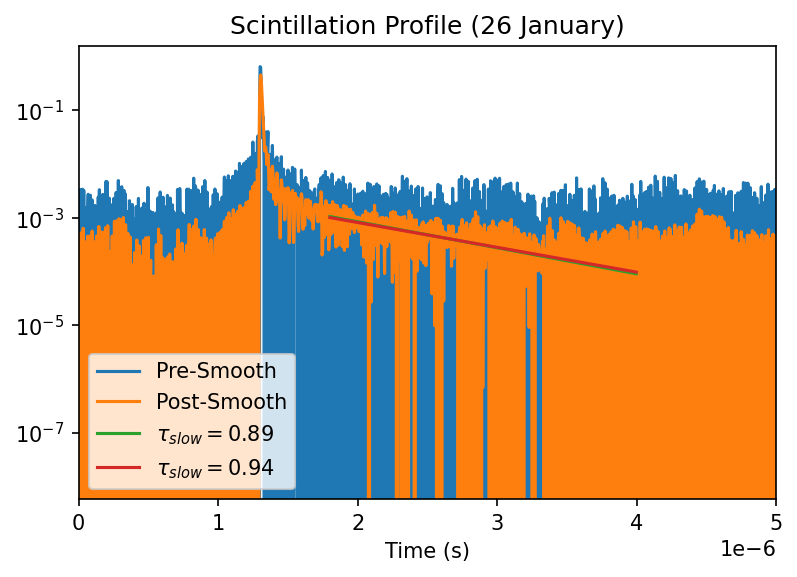

In [10]:
deconvolution_noise('run79_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run85_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 0, "26 January")

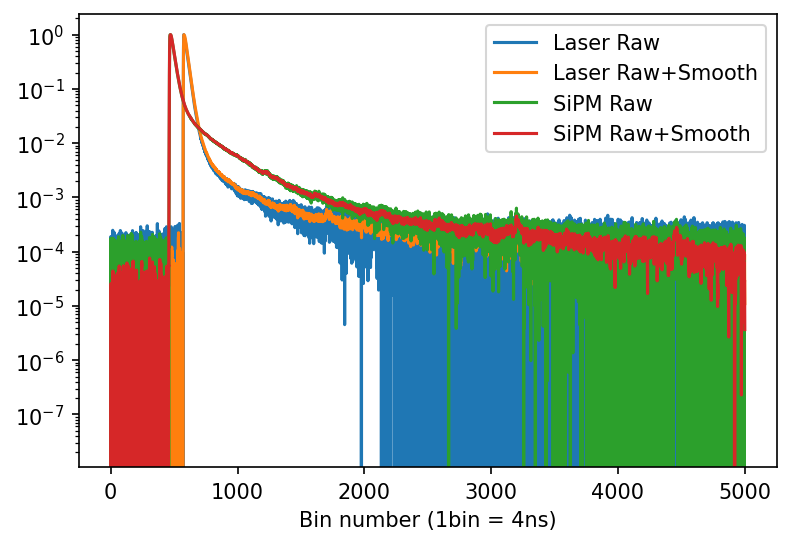

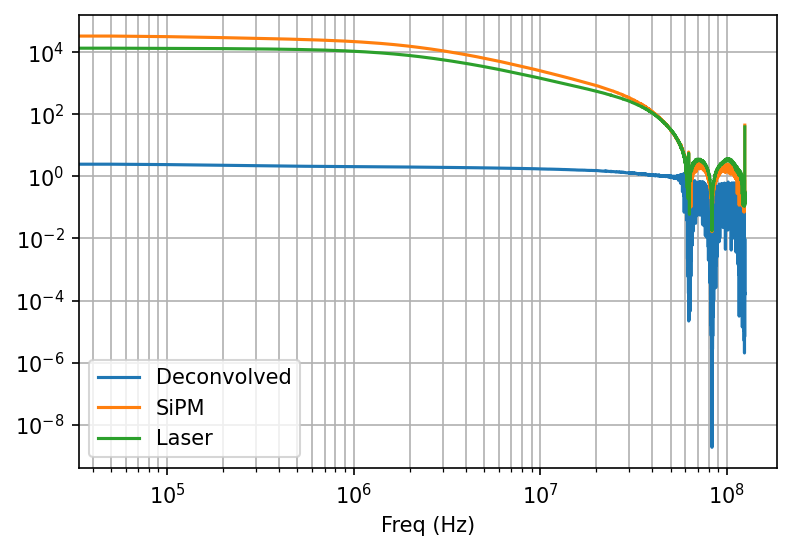

Check deconvolved time!!


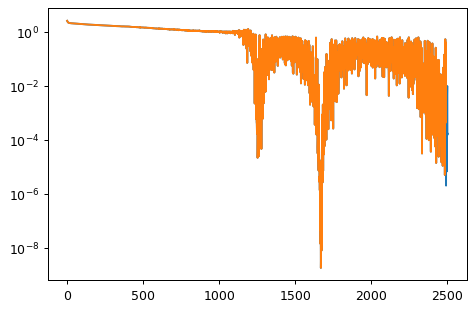

T_slow (pre-smooth) = 9.170972923492471e-07
T_slow (post-smooth) = 9.147842208401355e-07


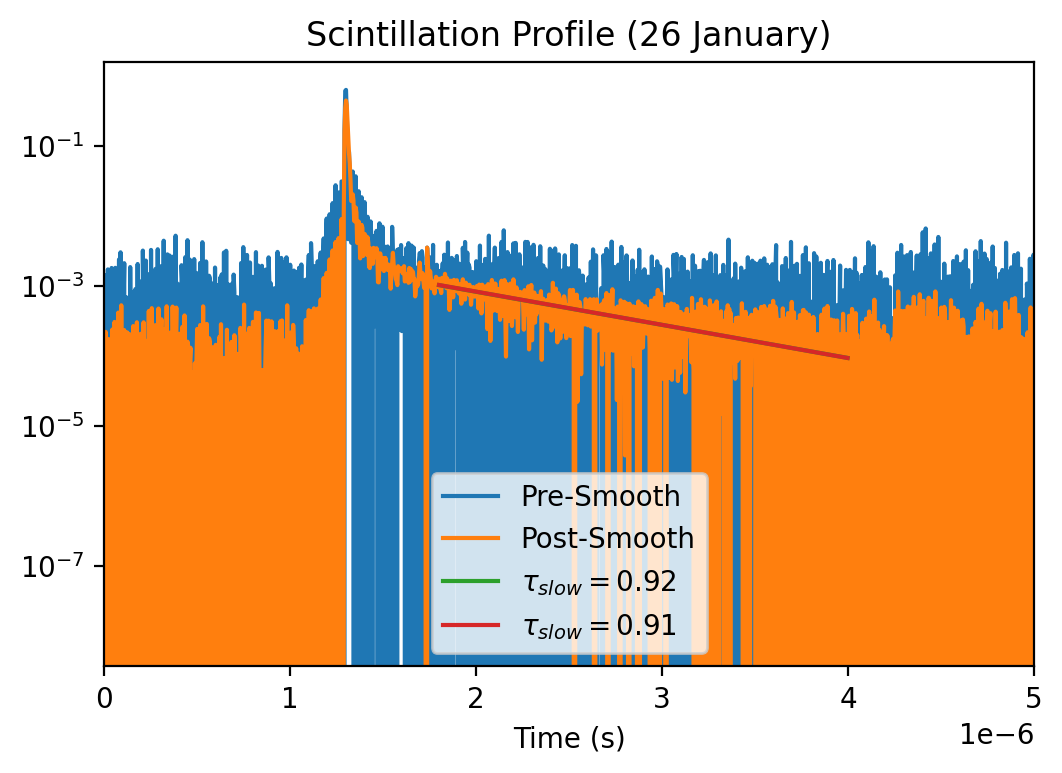

In [27]:
deconvolution_noise('run79_ScintProfFirstSignalBin_SiPM.root', 'run59_ScintProfFirstSignalBin_SiPM.root', 'run85_ScintProfFirstSignalBin_SiPM_Noise.root',
                    2490, 450, 1000, 1, "26 January")